# script for preprocessing datacube
## 1. create .vrt files for each band

In [1]:
import os
import re
import subprocess
from collections import defaultdict
import numpy as np
import rasterio
from rasterio.merge import merge
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
#import geopandas as gpd
import pandas as pd

# PATHS
# === Paths ===
VRT_FOLDER =  "/Users/felix/Documents/TUM_LOCAL/TREE/10_Data/S2_Summer_Median/VRT"  
ALS_PATH1 = '/Users/felix/Documents/TUM_LOCAL/TREE/01_Repo/TreeHeads/data/ALS_GT01_2024.tif'
ALS_PATH1_P = '/Users/felix/Documents/TUM_LOCAL/TREE/01_Repo/TreeHeads/data/ALS_GT01_2024_processed.tif'
ALS_PATH2 = '/Users/felix/Documents/TUM_LOCAL/TREE/01_Repo/TreeHeads/data/ALS_GT02_2024.tif'
ALS_PATH2_P = '/Users/felix/Documents/TUM_LOCAL/TREE/01_Repo/TreeHeads/data/ALS_GT02_2024_processed.tif'

# CUTLINE_GEOJSON = "./als_cutline.geojson"
OUTPUT_FOLDER = "./processed"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

## Get some ALS Stats

In [101]:
def plot_ALS_histogram(als_path, output_folder):
    """
    Plot histogram of ALS data.
    """
    # plot histogram of ALS data
    with rasterio.open(als_path) as src:
        als_data = src.read(1).astype(np.float32)

    # === Mask out nodata and NaNs (e.g., 0 or -9999 can be nodata in ALS)
    als_data = als_data[~np.isnan(als_data)]
    # als_data = als_data[als_data <=120]  # optional: remove zeroes if they're nodata
    # als_data = als_data[als_data >= 0]  # optional: filter a known nodata

    # === Plot histogram ===
    percentiles = [0,5,10,90, 95, 97.5, 98, 99, 100]
    values = als_data
    perc_values = np.percentile(values, percentiles)

    plt.figure(figsize=(8, 5))
    plt.hist(values, bins=256, color='skyblue', edgecolor='black', alpha=0.7)
    for p, v in zip(percentiles, perc_values):
        plt.axvline(v, color='r', linestyle='--', label=f'{p}th: {v:.2f}')
    plt.title("ALS Pixel Value Histogram with Percentiles")
    plt.xlabel("Canopy Height (m)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    #plt.savefig(os.path.join(output_folder, 'histogram.png'+als_path))


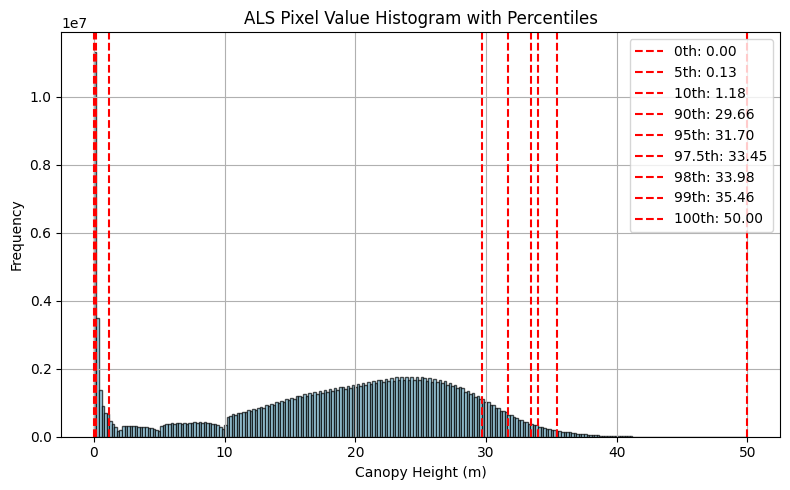

In [102]:
plot_ALS_histogram(ALS_PATH1_P, OUTPUT_FOLDER)

### ALS Outlier removal

In [4]:
import rasterio
import numpy as np

# Open the ALS TIFF file
with rasterio.open(ALS_PATH2) as src:
    als_data = src.read(1).astype(np.float32)  # Read the first band
    profile = src.profile  # Get the metadata/profile of the file

# Replace values <0 or >50 with NaN
als_data = np.where((als_data < 0) | (als_data > 50), np.nan, als_data)

# Update the profile to handle NaN values (set nodata value)
profile.update(dtype=rasterio.float32, nodata=np.nan)

# Save the processed data back to a new TIFF file
processed_tif_path = os.path.join('./data', "ALS_GT02_2024_processed.tif")
with rasterio.open(processed_tif_path, 'w', **profile) as dst:
    dst.write(als_data, 1)  # Write the processed data to the first band

print(f"✅ Processed TIFF saved to: {processed_tif_path}")

✅ Processed TIFF saved to: ./data/ALS_GT02_2024_processed.tif


In [9]:
def unify_als_files(als_path1, als_path2, output_path):
    """
    Unify two ALS files by merging them and saving to output_path.
    """
    with rasterio.open(als_path1) as src1, rasterio.open(als_path2) as src2:
        merged_data, merged_transform = merge([src1, src2])
        profile = src1.profile.copy()
        profile.update({
            'height': merged_data.shape[1],
            'width': merged_data.shape[2],
            'transform': merged_transform,
            'nodata': np.nan
        })
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(merged_data[0], 1)  # Write the first band only
    print(f"✅ Unified ALS file saved to: {output_path}")

unify_als_files(
    ALS_PATH1_P,
    ALS_PATH2_P,
    ALS_PATH1_P.replace('GT01_2024_processed.tif', 'GT0102_2024_processed_unified.tif')
)


: 

### RGB Channel Stats

## Do the S2 <> ALS DATA Wrangling
### convert to .vrt first for handling each band nicely

In [7]:
# === CONFIG ===
root_dir = "/Users/felix/Documents/TUM_LOCAL/TREE/10_Data/S2_Summer_Median"  # <-- Change this!
recursive = True                   # Set to False if you don't want recursion
vrt_output_dir = root_dir + '/VRT'         # Where to save the VRTs

# === STEP 1: Gather all .tif files ===
tif_files = []
for root, _, files in os.walk(root_dir):
    for f in files:
        if f.lower().endswith('.tif'):
            tif_files.append(os.path.join(root, f))
    if not recursive:
        break

# === STEP 2: Group files by band suffix ===
band_groups = defaultdict(list)

pattern = re.compile(r"_SEN2L_(.+?)\.tif$", re.IGNORECASE)
for f in tif_files:
    match = pattern.search(os.path.basename(f))
    if match:
        band = match.group(1)  # e.g., "BLU_STM"
        band_groups[band].append(f)
        #print(f"Found {band} file: {f}")

if True:
# === STEP 3: Create VRTs using gdalbuildvrt ===
    for band, files in band_groups.items():
        vrt_path = os.path.join(vrt_output_dir, f"{band}.vrt")
        print(f"Creating {vrt_path} with {len(files)} files...")

        # Write file list
        list_path = os.path.join(vrt_output_dir, f"list_{band}.txt")
        with open(list_path, "w") as f:
            for tif in files:
                f.write(f"{tif}\n")

        # Call gdalbuildvrt
        subprocess.run([
            "gdalbuildvrt",
            "-input_file_list", list_path,
            vrt_path
        ], check=True)

        os.remove(list_path)

    print("✅ Done! One VRT per band has been created.")


Creating /Users/felix/Documents/TUM_LOCAL/TREE/10_Data/S2_Summer_Median/VRT/EVI_STM.vrt with 51 files...
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating /Users/felix/Documents/TUM_LOCAL/TREE/10_Data/S2_Summer_Median/VRT/RED_STM.vrt with 51 files...
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating /Users/felix/Documents/TUM_LOCAL/TREE/10_Data/S2_Summer_Median/VRT/NDV_STM.vrt with 51 files...
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating /Users/felix/Documents/TUM_LOCAL/TREE/10_Data/S2_Summer_Median/VRT/RE3_STM.vrt with 51 files...
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating /Users/felix/Documents/TUM_LOCAL/TREE/10_Data/S2_Summer_Median/VRT/NIR_STM.vrt with 51 files...
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating /Users/felix/Documents/TUM_LOCAL/TREE/10_Data/S2_Summer_Median/VRT/BLU_STM.vrt with 51 files...
0...10...20...30...40...50...60...70...80...90...100 - done.
Crea

In [8]:
print(band_groups.keys())  # print the keys of the band groups
# save the band groups to a file such that i can access only the band names (keys) as an array later   

dict_keys(['EVI_STM', 'RED_STM', 'NDV_STM', 'RE3_STM', 'NIR_STM', 'BLU_STM', 'NBR_STM', 'RE2_STM', 'SW2_STM', 'BNR_STM', 'GRN_STM', 'RE1_STM', 'SW1_STM'])


## Align S2 and ALS Data
Goal: process a data ready for training. 
1. take .vrt for each channel for the full training data.
2. for each band in bands: 
    use gdalwarp, cutline option for cropping to the Intersection with als.tif (ground-truth data)
    np.stack()
3. one big .tif -> load with rasterio -> convert to numpy / or xarray 
4. 2 img: ALS, S2. use kernel 256x256 patches
5. then do traintestvalsplit 
5. display with matplotlib (imdotshow with rgb)
6. do another check with qgis 

### use polygon cutline -> memory heavy (30GB) -> do bounding box

In [ ]:
# convert to ploygons before cutline cropping:
import os
import glob
import subprocess

# === Paths ===
VRT_FOLDER =  "/Users/felix/Documents/TUM_LOCAL/TREE/10_Data/S2_Summer_Median/VRT"  
ALS_PATH = '/Users/felix/Documents/TUM_LOCAL/TREE/01_Repo/TreeHeads/data/ALS_GT01_2024.tif'
CUTLINE_GEOJSON = "./als_cutline.geojson"
OUTPUT_FOLDER = "./processed"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# === Step 1: Polygonize ALS Raster ===
if not os.path.exists(CUTLINE_GEOJSON):
    print("Creating polygon cutline from ALS raster...")
    subprocess.run([
        "gdal_polygonize.py",
        ALS_PATH,
        "-f", "GeoJSON",
        CUTLINE_GEOJSON
    ], check=True)
else:
    print("Cutline already exists, skipping polygonize.")

# === Step 2: Warp each VRT using the cutline ===
vrt_files = glob.glob(os.path.join(VRT_FOLDER, "*.vrt"))

for vrt in vrt_files:
    band_name = os.path.splitext(os.path.basename(vrt))[0]
    output_tif = os.path.join(OUTPUT_FOLDER, f"{band_name}_cropped.tif")

    if os.path.exists(output_tif):
        print(f"[SKIP] {output_tif} already exists.")
        continue

    print(f"[WARP] Cropping {band_name}...")

    cmd = [
        "gdalwarp",
        "-cutline", CUTLINE_GEOJSON,
        "-crop_to_cutline",
        "-dstalpha",  # add transparency for no-data
        "-of", "GTiff",
        "-overwrite",
        vrt,
        output_tif
    ]

    try:
        subprocess.run(cmd, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    except subprocess.CalledProcessError as e:
        print(f"[ERROR] gdalwarp failed for {band_name}")
        print(e.stderr.decode())

print("\n✅ All VRTs processed and cropped.")


### use bounding box cropping

In [8]:
import rasterio

# CROP USING BOUNDING BOX
# === Step 1: Get Bounding Box from ALS raster ===
# Get bounds and CRS from both ALS rasters
with rasterio.open(ALS_PATH) as src1, rasterio.open(ALS_PATH2) as src2:
    bounds1 = src1.bounds
    bounds2 = src2.bounds
    crs1 = src1.crs
    crs2 = src2.crs

    # Ensure both rasters have the same CRS
    if crs1 != crs2:
        raise ValueError("CRS of ALS_PATH and ALS_PATH2 do not match!")

    # Calculate the union bounding box
    min_left = min(bounds1.left, bounds2.left)
    min_bottom = min(bounds1.bottom, bounds2.bottom)
    max_right = max(bounds1.right, bounds2.right)
    max_top = max(bounds1.top, bounds2.top)

    bounds = rasterio.coords.BoundingBox(left=min_left, bottom=min_bottom, right=max_right, top=max_top)
    crs = crs1


# === Step 2: Warp each VRT using bounding box ===
vrt_files = glob.glob(os.path.join(VRT_FOLDER, "*.vrt"))

for vrt in vrt_files:
    band_name = os.path.splitext(os.path.basename(vrt))[0]
    output_tif = os.path.join(OUTPUT_FOLDER, f"{band_name}_cropped.tif")

    if os.path.exists(output_tif):
        print(f"[SKIP] {output_tif} already exists.")
        continue

    print(f"[WARP] Cropping {band_name}...")

    cmd = [
        "gdalwarp",
        "-te", str(bounds.left), str(bounds.bottom), str(bounds.right), str(bounds.top),
        "-te_srs", crs.to_string(),
        "-of", "GTiff",
        "-overwrite",
        vrt,
        output_tif
    ]

    try:
        subprocess.run(cmd, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    except subprocess.CalledProcessError as e:
        print(f"[ERROR] gdalwarp failed for {band_name}")
        print(e.stderr.decode())

print("\n✅ All VRTs processed and cropped using bounding box.")

[SKIP] ./processed/RED_STM_cropped.tif already exists.
[SKIP] ./processed/EVI_STM_cropped.tif already exists.
[SKIP] ./processed/NDV_STM_cropped.tif already exists.
[SKIP] ./processed/GRN_STM_cropped.tif already exists.
[SKIP] ./processed/SW1_STM_cropped.tif already exists.
[SKIP] ./processed/RE1_STM_cropped.tif already exists.
[SKIP] ./processed/NBR_STM_cropped.tif already exists.
[SKIP] ./processed/BLU_STM_cropped.tif already exists.
[SKIP] ./processed/NIR_STM_cropped.tif already exists.
[SKIP] ./processed/RE3_STM_cropped.tif already exists.
[SKIP] ./processed/SW2_STM_cropped.tif already exists.
[SKIP] ./processed/BNR_STM_cropped.tif already exists.
[SKIP] ./processed/RE2_STM_cropped.tif already exists.

✅ All VRTs processed and cropped using bounding box.


### Stack S2 into one tif

In [3]:
# === CONFIG ===

BAND_TIFS = sorted(glob.glob('./processed/*_cropped.tif'))  # e.g., [B02_cropped.tif, B03_cropped.tif, ...]
# ALS_PATH = "/full/path/to/Ebrach_Mosaik_pitt-free_nDOM_2024.tif"
STACKED_OUTPUT = "./stacked_multiband.tif"

# === STEP 1: STACK CROPPED BANDS INTO ONE MULTIBAND FILE ===
def stack_bands(band_paths, out_path):
    sample = rasterio.open(band_paths[0])
    meta = sample.meta.copy()
    meta.update(count=len(band_paths))
    
    with rasterio.open(out_path, 'w', **meta) as dst:
        for i, path in enumerate(band_paths, start=1):
            with rasterio.open(path) as src:
                dst.write(src.read(1), i)
    print(f"✅ Stacked {len(band_paths)} bands into {out_path}")
    return out_path

if os.path.exists(STACKED_OUTPUT):
    print(f"✅ Loaded existing stacked file: {STACKED_OUTPUT}")
    stack_path = STACKED_OUTPUT
else:
    print(f"❌ Stacked file not found. Creating new stack...")
    # stack the bands
    stack_path = stack_bands(BAND_TIFS, STACKED_OUTPUT)

✅ Loaded existing stacked file: ./stacked_multiband.tif


In [4]:
stack_path

'./stacked_multiband.tif'

## resample ALS data

In [15]:
def load_rasters(stack_path, als_path1, als_path2):
    with rasterio.open(stack_path) as s2_src:
        s2np = s2_src.read().astype(np.float32)  # shape: (bands, height, width)
    # Open both ALS rasters
    with rasterio.open(als_path1) as src1, rasterio.open(als_path2) as src2:
        # Merge ALS rasters into one (union extent)
        als_merged, _ = merge([src1, src2])
        alsnp = als_merged[0].astype(np.float32)  # shape: (height, width)
    print(f"✅ Loaded S2: {s2np.shape}, ALS merged: {alsnp.shape}")
    return s2np, alsnp #, s2_src, als_merged

# Load S2 and merged ALS data
s2_np, als_np = load_rasters(stack_path, ALS_PATH1, ALS_PATH2)


✅ Loaded S2: (13, 2517, 5661), ALS merged: (50347, 113216)


In [50]:
test = np.array([[np.nan,2,3,4,5,np.nan,7,np.nan,9,10,11]], dtype=np.float32)
#test = np.ones((1,7), dtype=np.float32)
p = np.percentile(test[~np.isnan(test)], 90)

t2 = np.clip(test, None, p)
t2

array([[      nan,  2.      ,  3.      ,  4.      ,  5.      ,       nan,
         7.      ,       nan,  9.      , 10.      , 10.299999]],
      dtype=float32)

## Rasterio Resampling

In [81]:
import rasterio
from rasterio.warp import reproject, Resampling
import numpy as np

def aggregate_als_to_s2_percentile(als_path, s2_path, percentile=99):
    # Open S2 stack to get shape, transform, and CRS
    with rasterio.open(s2_path) as s2_src:
        s2_shape = (s2_src.height, s2_src.width)
        s2_transform = s2_src.transform
        s2_crs = s2_src.crs

    # Open ALS raster
    with rasterio.open(als_path) as als_src:
        als_data = als_src.read(1).astype(np.float32)
        # Calculate the x-th percentile and clip upper values
        perc = np.percentile(als_data[~np.isnan(als_data)], percentile)
        als_data = np.clip(als_data, None, perc)

        als_transform = als_src.transform 
        als_crs = als_src.crs

        # Prepare output array
        als_resampled = np.full(s2_shape, np.nan, dtype=np.float32)

        # Use rasterio's reproject with max aggregation to downsample
        reproject(
            source=als_data,
            destination=als_resampled,
            src_transform=als_transform,
            src_crs=als_crs,
            dst_transform=s2_transform,
            dst_crs=s2_crs,
            resampling=Resampling.max
        )
    print(f"✅ Resampled ALS to S2 shape: {als_resampled.shape}, S2 shape: {s2_shape}; percentile: {percentile}th")
    return als_resampled

# Example usage:
als_percentile1 = aggregate_als_to_s2_percentile(ALS_PATH1_P, stack_path, percentile=98)
als_percentile2 = aggregate_als_to_s2_percentile(ALS_PATH2_P, stack_path, percentile=98)
als_percentile = als_percentile1 + als_percentile2
#print(als_percentile.shape)


✅ Resampled ALS to S2 shape: (2517, 5661), S2 shape: (2517, 5661); percentile: 98th
✅ Resampled ALS to S2 shape: (2517, 5661), S2 shape: (2517, 5661); percentile: 98th


In [88]:

#np.nanmax(np.dstack([als_percentile1, als_percentile2]), axis=2)
# count nan of als_percentile
np.count_nonzero(np.isnan(als_percentile1))

0

In [83]:

np.count_nonzero(np.isnan(als_percentile1)+np.isnan(als_percentile2))

0

## old versions of resampling with kernel windows

In [ ]:
# new version of resampling
from math import ceil

def downsample_als_to_s2_percentile(als, s2, percentile=99):
    """
    Downsample ALS data to S2 resolution using a moving window (kernel) and compute the given percentile.

    Parameters:
    - als: 2D numpy array (ALS data, high-res)
    - s2: 3D numpy array (S2 data, shape: bands, height, width)
    - percentile: int or float, percentile to compute (0-100)

    Returns:
    - als_percentile: 2D numpy array (downsampled ALS, shape: S2 height, S2 width)
    """

    s2_height, s2_width = s2.shape[1], s2.shape[2]
    als_height, als_width = als.shape

    # Compute kernel size (round up to cover the ALS grid)
    kernel_y = int(ceil(als_height / s2_height))
    kernel_x = int(ceil(als_width / s2_width))

    # Pad ALS so that the moving window covers the full S2 grid
    pad_y = (s2_height * kernel_y - als_height)
    pad_x = (s2_width * kernel_x - als_width)
    pad_top = pad_y // 2
    pad_bottom = pad_y - pad_top
    pad_left = pad_x // 2
    pad_right = pad_x - pad_left

    als_padded = np.pad(
        als,
        ((pad_top, pad_bottom), (pad_left, pad_right)),
        mode='constant',
        constant_values=np.nan
    )

    als_percentile = np.full((s2_height, s2_width), np.nan, dtype=np.float32)

    for i in range(s2_height):
        for j in range(s2_width):
            y_start = i * kernel_y
            y_end = y_start + kernel_y
            x_start = j * kernel_x
            x_end = x_start + kernel_x
            patch = als_padded[y_start:y_end, x_start:x_end]
            patch = patch[~np.isnan(patch)]
            if patch.size > 0:
                als_percentile[i, j] = np.percentile(patch, percentile)
            else:
                als_percentile[i, j] = np.nan

    print(f"✅ Downsampled ALS to S2 resolution using {percentile}th percentile: shape {als_percentile.shape}")
    return als_percentile

# Example usage:
als_percentile = downsample_als_to_s2_percentile(als_np, s2_np, percentile=95)

✅ Downsampled ALS to S2 resolution using 95th percentile: shape (2517, 5661)


In [ ]:
# OLD BUGGY VERSION!
def downsample_als_to_s2(als, s2):
    s2_shape = s2.shape
    s2_height, s2_width = s2_shape[1], s2_shape[2]
    als_height, als_width = als.shape

    scale_y = als_height // s2_height
    scale_x = als_width // s2_width

    als_mean = np.zeros((s2_height, s2_width), dtype=np.float32)
    als_std = np.zeros((s2_height, s2_width), dtype=np.float32)

    for i in range(s2_height):
        for j in range(s2_width):
            y_start, y_end = i * scale_y, (i + 1) * scale_y
            x_start, x_end = j * scale_x, (j + 1) * scale_x
            als_patch = als[y_start:y_end, x_start:x_end]
            als_patch = als_patch[~np.isnan(als_patch)]
            if als_patch.size > 0:
                als_mean[i, j] = np.mean(als_patch)
                als_std[i, j] = np.std(als_patch)
            else:
                als_mean[i, j] = np.nan
                als_std[i, j] = np.nan

    print(f"✅ Downsampled ALS to S2 resolution: mean shape {als_mean.shape}, std shape {als_std.shape}")
    return als_mean, als_std

# Downsample ALS and compute mean and std
als_mean, als_std = downsample_als_to_s2(als_np, s2_np)

## some plotting for intuition

In [ ]:
def plot_RGB_stats(s2, band_idxs=(10,3,0),normalize=True):
    """
    Plot RGB image and histograms of each band.

    Parameters:
    - s2: numpy array of S2 data (bands, height, width)
    - band_idxs: tuple of band indices for RGB channels (default: (11, 4, 1))
    """

    if normalize:
        # Normalize RGB values to [0, 1]
        # assign nan to values < 0
        s2[s2 < 0] = np.nan
        s2 = np.clip(s2, 0, np.nanpercentile(s2, 50))
        s2 = (s2 - np.nanmin(s2)) / (np.nanmax(s2) - np.nanmin(s2))
        #rgb = np.clip(rgb, 0, rgb.max())
        #rgb = (rgb - np.min(rgb)) / (np.max(rgb) - np.min(rgb))
        
        pass

    # Extract RGB bands for S2
    rgb = s2[band_idxs, :, :].transpose(1, 2, 0)  # shape: (height, width, bands)
    #rgb = s2[band_idxs].transpose(1, 2, 0)  # shape: (height, width, bands)
    plt.figure(figsize=(12, 6))
    
    # Plot RGB image
    plt.subplot(1, 4, 1)
    plt.imshow(rgb)
    plt.title("RGB Image of S2")
    plt.axis('off')

    # Plot histograms for each band
    for i, idx in enumerate(band_idxs):
        plt.subplot(1, 4, i + 2)
        plt.hist(s2[idx].flatten(), bins=256, color='blue', edgecolor='black')
        plt.title(f"Band {idx + 1} Histogram")
        plt.xlabel("Pixel Value")
        plt.ylabel("Frequency")
        plt.grid(True)

    plt.tight_layout()
    plt.show()
# Plot RGB image and histograms
plot_RGB_stats(s2_np,normalize=False)  # Adjust band indices as needed

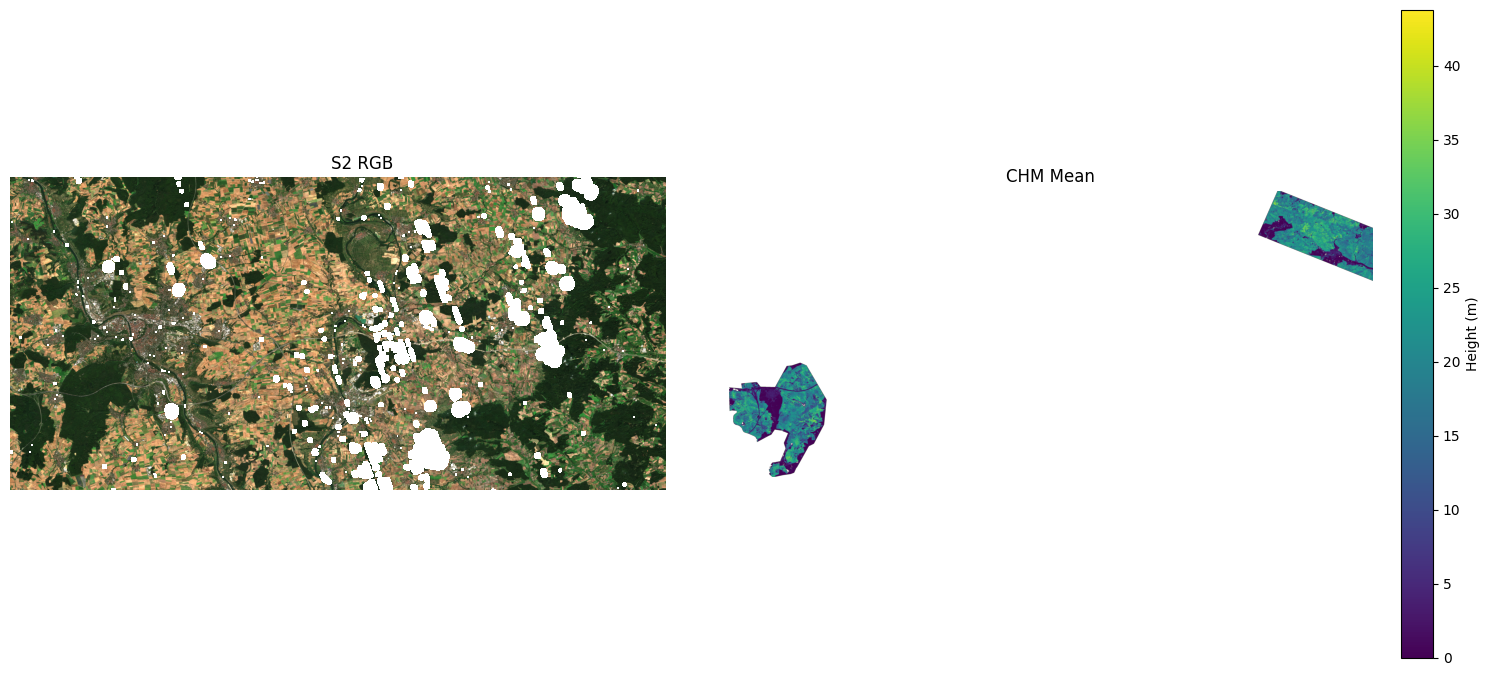

In [16]:
def plot_full_image(s2, als_mean, band_idxs=(10, 3, 0)):
    """
    Plot the full image of S2 data (RGB) and ALS mean.

    Parameters:
    - s2: numpy array of S2 data (bands, height, width)
    - als_mean: numpy array of ALS mean data (height, width)
    - band_idxs: tuple of band indices for RGB visualization (default: (11, 4, 1))
    """

    s2[s2 < 0] = np.nan
    s2 = np.clip(s2, 0, np.nanpercentile(s2, 50))
    s2 = (s2 - np.nanmin(s2)) / (np.nanmax(s2) - np.nanmin(s2))
    rgb = s2[band_idxs, :, :].transpose(1, 2, 0)  # shape: (height, width, bands)

    fig, axs = plt.subplots(1, 2, figsize=(15, 7))

    # Plot S2 RGB
    axs[0].imshow(rgb)
    axs[0].set_title("S2 RGB")
    axs[0].axis("off")

    # Plot ALS mean
    im = axs[1].imshow(als_mean, cmap='viridis')
    axs[1].set_title("CHM Mean")
    axs[1].axis("off")
    cbar = fig.colorbar(im, ax=axs[1], orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label("Height (m)")

    plt.tight_layout()
    plt.show()

# Example usage
plot_full_image(s2_np, als_mean)

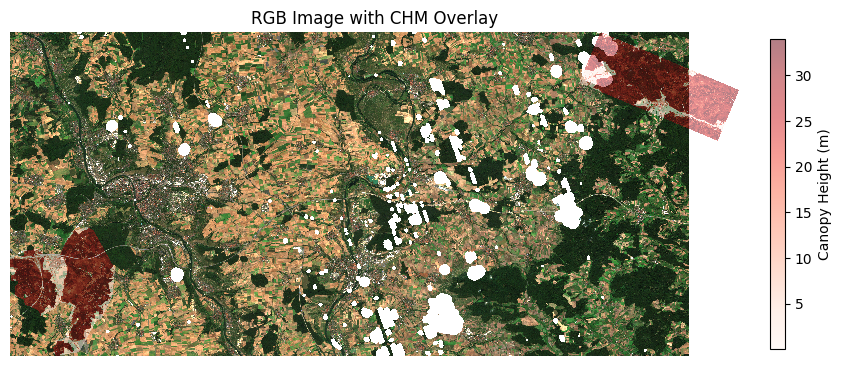

In [82]:
def plot_overlay(s2, als, band_idxs=(10, 3, 0), alpha=0.5):
    """
    Plot an overlay of the RGB image and ALS data.

    Parameters:
    - s2: numpy array of S2 data (bands, height, width)
    - als: numpy array of ALS data (height, width)
    - band_idxs: tuple of band indices for RGB visualization (default: (10, 3, 0))
    - alpha: transparency level for the ALS overlay (default: 0.5)
    """
    # Normalize RGB values for visualization
    s2[s2 < 0] = np.nan
    s2 = np.clip(s2, 0, np.nanpercentile(s2, 50))
    s2 = (s2 - np.nanmin(s2)) / (np.nanmax(s2) - np.nanmin(s2))
    rgb = s2[band_idxs, :, :].transpose(1, 2, 0)  # shape: (height, width, bands)

    als[als == 0] = np.nan

    # Plot RGB image
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb, interpolation='none')
    plt.imshow(als, cmap='Reds', alpha=alpha, interpolation='none')  # Overlay ALS data
    plt.title("RGB Image with CHM Overlay")
    plt.axis("off")
    plt.colorbar(label="Canopy Height (m)", fraction=0.02,pad=0.04,)
    plt.tight_layout
    plt.show()

# Example usage
plot_overlay(s2_np, als_percentile)

In [90]:
# Compare pixel count of ALS vs S2
als_pixel_count = np.prod(als_np.shape)
s2_pixel_count = np.prod(s2_np.shape[1:])  # Only height x width for S2

print(f"ALS pixel count: {als_pixel_count}")
print(f"S2 pixel count: {s2_pixel_count}")
print(f"ratio is {als_pixel_count/s2_pixel_count}")

ALS pixel count: 5700085952
S2 pixel count: 14248737
ratio is 400.0414880280266


In [92]:
np.nanmax(als_data)

np.float32(50.0)

In [115]:
def extract_patches_with_resampled_data(s2, als_mean, als_std, patch_size, only_full_patches=False):
    """
    Extract patches from S2 data and resampled ALS data (mean and std).

    Parameters:
    - s2: numpy array of S2 data (bands, height, width)
    - als_mean: numpy array of resampled ALS mean values (height, width)
    - als_std: numpy array of resampled ALS std values (height, width)
    - patch_size: size of the patches to extract
    - only_full_patches: if True, only return patches with no NaN/missing data

    Returns:
    - s2_patches: numpy array of S2 patches with ALS mean and std as additional bands
    - als_mean_patches: numpy array of ALS mean ground truth patches
    - als_std_patches: numpy array of ALS std ground truth patches
    - combined_patches: numpy array of combined patches (S2 + ALS mean + ALS std)
    """
    _, h, w = s2.shape
    patches_s2, patches_als_mean, patches_als_std, combined_patches = [], [], [], []
    full_patch_count = 0

    for i in range(0, h - patch_size + 1, patch_size):
        for j in range(0, w - patch_size + 1, patch_size):
            s2_patch = s2[:, i:i+patch_size, j:j+patch_size]
            als_mean_patch = als_mean[i:i+patch_size, j:j+patch_size]
            als_std_patch = als_std[i:i+patch_size, j:j+patch_size]

            combined_patch = np.concatenate(
                [s2_patch, als_mean_patch[np.newaxis, :, :], als_std_patch[np.newaxis, :, :]], axis=0
            )

            has_nan = np.isnan(combined_patch).any()
            if not has_nan:
                full_patch_count += 1

            if only_full_patches and has_nan:
                continue

            patches_s2.append(s2_patch)
            patches_als_mean.append(als_mean_patch)
            patches_als_std.append(als_std_patch)
            combined_patches.append(combined_patch)

    s2_arr = np.stack(patches_s2) if patches_s2 else np.empty((0, s2.shape[0], patch_size, patch_size))
    als_mean_arr = np.stack(patches_als_mean) if patches_als_mean else np.empty((0, patch_size, patch_size))
    als_std_arr = np.stack(patches_als_std) if patches_als_std else np.empty((0, patch_size, patch_size))
    combined_arr = np.stack(combined_patches) if combined_patches else np.empty((0, s2.shape[0]+2, patch_size, patch_size))

    #print(f"✅ Extracted {len(s2_arr)} patches with resampled data")
    #print(f"✅ {full_patch_count} patches contain no NaN/missing data")
    print(f"Patch size: {patch_size}, Number of patches: {len(s2_arr)}, Full patches (no NaN): {full_patch_count}")
    return s2_arr, als_mean_arr, als_std_arr, combined_arr


In [118]:
patches = [32,64,128,256]

for p in patches:
    #print(f"Extracting patches of size {p}...")
    s2_arr, als_mean_arr, als_std_arr, combined_arr = extract_patches_with_resampled_data(s2_np, als_percentile, als_percentile, p, only_full_patches=False)
#s2_arr, als_mean_arr, als_std_arr, combined_arr = extract_patches_with_resampled_data(s2_np, als_percentile, als_percentile, 128, only_full_patches=False)

Patch size: 32, Number of patches: 13728, Full patches (no NaN): 734
Patch size: 64, Number of patches: 3432, Full patches (no NaN): 110
Patch size: 128, Number of patches: 836, Full patches (no NaN): 10
Patch size: 256, Number of patches: 198, Full patches (no NaN): 0


## data size stats

In [128]:
def calculate_coverage_and_area(als, s2, band_idx=3, pixel_size=10):
    """
    Calculate the coverage and overlap between ALS and a specific S2 band.

    Parameters:
    - als: numpy array of ALS data (height, width)
    - s2: numpy array of S2 data (bands, height, width)
    - band_idx: index of the S2 band to compare (default: 3 for green channel)
    - pixel_size: size of one pixel in meters (default: 10m x 10m)

    Returns:
    - valid_pixel_count: number of valid overlapping pixels
    - percentage: percentage of ALS pixels with valid S2 data
    - area: area in square meters of valid overlapping pixels
    """
    # Mask invalid ALS and S2 data
    als_valid = ~np.isnan(als) & (als >= 0)
    s2_valid = ~np.isnan(s2[band_idx]) & (s2[band_idx] >= 0)

    # Calculate overlap
    valid_overlap = als_valid & s2_valid
    valid_pixel_count = np.sum(valid_overlap)

    # Calculate percentage and area
    total_als_pixels = np.sum(als_valid)
    percentage = (valid_pixel_count / total_als_pixels) * 100 if total_als_pixels > 0 else 0
    als_area_full = np.sum(als_valid) * (pixel_size ** 2) / 1e6   # Area in square kilometers
    area_km2_avail = valid_pixel_count * (pixel_size ** 2) / 1e6  # Convert to square kilometers

    # Calculate percentage of vegetated area with data availability
    vegetated_area = np.sum((als_mean > 2) & ~np.isnan(als_mean))
    vegetated_overlap = np.sum((als_mean > 2) & valid_overlap)
    vegetated_percentage = (vegetated_overlap / vegetated_area) * 100 if vegetated_area > 0 else 0

    return valid_pixel_count, percentage, als_area_full, area_km2_avail, vegetated_percentage

# Example usage
valid_pixel_count, percentage, als_area_full, area_km2_avail, vegetated_percentage = calculate_coverage_and_area(als_mean, s2_np, band_idx=3)
print(f"Area of valid CHM values (<0): {als_area_full:.2f} square kilometers")
print(f"Percentage of ALS pixels with valid S2 data: {percentage:.2f}%")
print(f"Valid overlapping pixels: {valid_pixel_count}")
print(f"Area of valid overlapping pixels: {area_km2_avail:.2f} square kilometers")
print(f"Percentage of vegetated area with data availability (100% = ALS Data where CHM>2m): {vegetated_percentage:.2f}%")


Area of valid CHM values (<0): 52.21 square kilometers
Percentage of ALS pixels with valid S2 data: 61.97%
Valid overlapping pixels: 323534
Area of valid overlapping pixels: 32.35 square kilometers
Percentage of vegetated area with data availability (100% = ALS Data where CHM>2m): 62.10%


In [129]:
import os

# Get file sizes in megabytes (MB)
als_file_size = os.path.getsize(ALS_PATH) / (1024 * 1024)  # Convert bytes to MB
s2_file_size = os.path.getsize(stack_path) / (1024 * 1024)  # Convert bytes to MB

print(f"ALS file size: {als_file_size:.2f} MB")
print(f"S2 stacked multiband file size: {s2_file_size:.2f} MB")

ALS file size: 447.65 MB
S2 stacked multiband file size: 26.04 MB


In [2]:
def plot_als_std_distribution(als_mean, als_std, threshold=2):
    """
    Plot the distribution of als_std values where als_mean > threshold.

    Parameters:
    - als_mean: numpy array of ALS mean values (height, width)
    - als_std: numpy array of ALS standard deviation values (height, width)
    - threshold: threshold value for als_mean to filter als_std (default: 2)
    """
    # Filter als_std where als_mean > threshold
    valid_std = als_std[als_mean > threshold]
    valid_std = valid_std[~np.isnan(valid_std)]  # Remove NaN values

    # Plot the distribution
    plt.figure(figsize=(8, 5))
    plt.hist(valid_std, bins=50, color='blue', edgecolor='black', alpha=0.7)
    plt.title(f"Distribution of CHM standard deviation (CHM_Mean > {threshold})")
    plt.xlabel("CHM Standard Deviation (m), after downsampling to S2")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage
plot_als_std_distribution(als_mean, als_std)

NameError: name 'als_mean' is not defined

In [ ]:
# === STEP 4: TRAIN/VAL/TEST SPLIT ===
def split_data(x, y, seed=42):
    x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=seed)
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=seed)
    print(f"✅ Data split: Train={len(x_train)}, Val={len(x_val)}, Test={len(x_test)}")
    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

(x_train, y_train), (x_val, y_val), (x_test, y_test) = split_data(s2_patches, als_patches)


In [13]:
import rasterio
from rasterio.warp import reproject, Resampling
import numpy as np
import glob
import os

# === INPUTS ===
#ALS_PATH = "/full/path/to/Ebrach_Mosaik_pitt-free_nDOM_2024.tif"
S2_BAND_PATHS = sorted(glob.glob("./processed/*_cropped.tif"))
PATCH_SIZE = 256

# === Load ALS reference grid ===
with rasterio.open(ALS_PATH) as als_src:
    als = als_src.read(1).astype(np.float32)
    als_profile = als_src.profile
    als_transform = als_src.transform
    als_shape = als.shape
    als_crs = als_src.crs

# === Reproject & resample each S2 band to ALS grid ===
stacked_bands = []

for path in S2_BAND_PATHS:
    with rasterio.open(path) as s2_src:
        s2_data = s2_src.read(1).astype(np.float32)
        s2_reproj = np.full(als_shape, np.nan, dtype=np.float32)

        reproject(
            source=s2_data,
            destination=s2_reproj,
            src_transform=s2_src.transform,
            src_crs=s2_src.crs,
            dst_transform=als_transform,
            dst_crs=als_crs,
            resampling=Resampling.bilinear
        )

        stacked_bands.append(s2_reproj)

s2_stack = np.stack(stacked_bands)  # shape: (bands, H, W)
print(f"✅ Resampled and stacked to shape: {s2_stack.shape} (matching ALS: {als.shape})")


✅ Resampled and stacked to shape: (13, 16910, 24821) (matching ALS: (16910, 24821))


In [ ]:
S2_BAND_PATHS = sorted(glob.glob("./processed/*_cropped.tif"))

def get_gsd(path):
    with rasterio.open(path) as src:
        res_x, res_y = src.res  # (pixel width, pixel height in coordinate units)
        crs = src.crs
        print(f"{os.path.basename(path)}:")
        print(f"  CRS: {crs}")
        print(f"  Ground Sampling Distance (GSD): {res_x:.2f} x {res_y:.2f} {crs.linear_units}\n")

# Example usage
get_gsd(ALS_PATH)
for path in S2_BAND_PATHS:
    get_gsd(path)



ALS_GT01_2024.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 0.50 x 0.50 metre

BLU_STM_cropped.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 10.00 x 9.99 metre

BNR_STM_cropped.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 10.00 x 9.99 metre

EVI_STM_cropped.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 10.00 x 9.99 metre

GRN_STM_cropped.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 10.00 x 9.99 metre

NBR_STM_cropped.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 10.00 x 9.99 metre

NDV_STM_cropped.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 10.00 x 9.99 metre

NIR_STM_cropped.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 10.00 x 9.99 metre

RE1_STM_cropped.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 10.00 x 9.99 metre

RE2_STM_cropped.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 10.00 x 9.99 metre

RE3_STM_cropped.tif:
  CRS: EPSG:25832
  Ground Sampling Distance (GSD): 

In [7]:
import os
import numpy as np
import rasterio
from rasterio.mask import mask
from rasterio.merge import merge
from rasterio.windows import Window
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm

# === CONFIG ===
VRT_DIR =  "/Users/felix/Documents/TUM_LOCAL/TREE/10_Data/S2_Summer_Median/VRT"  
ALS_PATH = '/Users/felix/Documents/TUM_LOCAL/TREE/01_Repo/TreeHeads/data/ALS_GT01_2024.tif'
#'/Users/felix/Documents/TUM_LOCAL/TREE/10_Data/Ebrach_Mosaik_pitt-free_nDOM_2024/Ebrach_Mosaik_pitt-free_nDOM_2024.tif'
OUTPUT_DIR = "./processed"
PATCH_SIZE = 256
BANDS = ['EVI_STM', 'RED_STM', 'NDV_STM', 'RE3_STM', 'NIR_STM', 'BLU_STM', 'NBR_STM', 'RE2_STM', 'SW2_STM', 'BNR_STM', 'GRN_STM', 'RE1_STM', 'SW1_STM']

os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Step 1: Warp VRTs to ALS extent ===
aligned_bands = []
for band in BANDS:
    vrt = os.path.join(VRT_DIR, f"{band}.vrt")
    warped = os.path.join(OUTPUT_DIR, f"{band}_cropped.tif")
    cmd = [
        "gdalwarp",
        "-cutline", ALS_PATH,
        "-crop_to_cutline",
        "-of", "GTiff",
        vrt, warped
    ]
    print(f"Cropping {band}...")
    os.system(" ".join(cmd))
    aligned_bands.append(warped)

# === Step 2: Stack bands into a single raster ===
print("Stacking bands...")
with rasterio.open(aligned_bands[0]) as src0:
    meta = src0.meta.copy()
    meta.update(count=len(BANDS))

    stacked_path = os.path.join(OUTPUT_DIR, "S2_stack.tif")
    with rasterio.open(stacked_path, 'w', **meta) as dst:
        for idx, band_path in enumerate(aligned_bands, start=1):
            with rasterio.open(band_path) as src:
                dst.write(src.read(1), idx)

# === Step 3: Load ALS and S2 stack as numpy arrays ===
with rasterio.open(stacked_path) as s2, rasterio.open(ALS_PATH) as als:
    assert s2.shape == als.shape, "Shape mismatch after cropping!"
    s2_data = s2.read()  # shape: (bands, height, width)
    als_data = als.read(1)  # shape: (height, width)

# === Step 4: Patch extraction ===
print("Extracting patches...")
patches_s2 = []
patches_als = []

h, w = als_data.shape
for i in tqdm(range(0, h - PATCH_SIZE, PATCH_SIZE)):
    for j in range(0, w - PATCH_SIZE, PATCH_SIZE):
        patch_s2 = s2_data[:, i:i+PATCH_SIZE, j:j+PATCH_SIZE]
        patch_als = als_data[i:i+PATCH_SIZE, j:j+PATCH_SIZE]

        if np.any(patch_als == als.nodata):  # Skip no-data patches
            continue

        patches_s2.append(patch_s2)
        patches_als.append(patch_als)

patches_s2 = np.stack(patches_s2)  # shape: (N, bands, H, W)
patches_als = np.stack(patches_als)  # shape: (N, H, W)

# === Step 5: Train/Val/Test Split ===
print("Splitting dataset...")
X_train, X_temp, y_train, y_temp = train_test_split(patches_s2, patches_als, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# === Step 6: Visualization ===
def show_rgb(image_stack, idx=0):
    rgb = np.transpose(image_stack[idx, [2, 1, 0], :, :], (1, 2, 0))
    rgb = (rgb - np.min(rgb)) / (np.max(rgb) - np.min(rgb))  # normalize
    plt.imshow(rgb)
    plt.title("RGB Patch")
    plt.axis("off")
    plt.show()

show_rgb(X_train)

# === Optional: Save output arrays ===
np.savez_compressed(os.path.join(OUTPUT_DIR, "dataset.npz"),
                    X_train=X_train, y_train=y_train,
                    X_val=X_val, y_val=y_val,
                    X_test=X_test, y_test=y_test)


Cropping EVI_STM...
Cropping RED_STM...
Cropping NDV_STM...
Cropping RE3_STM...
Cropping NIR_STM...
Cropping BLU_STM...


ERROR 1: Cannot open /Users/felix/Documents/TUM_LOCAL/TREE/01_Repo/TreeHeads/data/ALS_GT01_2024.tif.
ERROR 1: Cannot open /Users/felix/Documents/TUM_LOCAL/TREE/01_Repo/TreeHeads/data/ALS_GT01_2024.tif.
ERROR 1: Cannot open /Users/felix/Documents/TUM_LOCAL/TREE/01_Repo/TreeHeads/data/ALS_GT01_2024.tif.
ERROR 1: Cannot open /Users/felix/Documents/TUM_LOCAL/TREE/01_Repo/TreeHeads/data/ALS_GT01_2024.tif.
ERROR 1: Cannot open /Users/felix/Documents/TUM_LOCAL/TREE/01_Repo/TreeHeads/data/ALS_GT01_2024.tif.
ERROR 1: Cannot open /Users/felix/Documents/TUM_LOCAL/TREE/01_Repo/TreeHeads/data/ALS_GT01_2024.tif.


Cropping NBR_STM...
Cropping RE2_STM...
Cropping SW2_STM...
Cropping BNR_STM...
Cropping GRN_STM...
Cropping RE1_STM...


ERROR 1: Cannot open /Users/felix/Documents/TUM_LOCAL/TREE/01_Repo/TreeHeads/data/ALS_GT01_2024.tif.
ERROR 1: Cannot open /Users/felix/Documents/TUM_LOCAL/TREE/01_Repo/TreeHeads/data/ALS_GT01_2024.tif.
ERROR 1: Cannot open /Users/felix/Documents/TUM_LOCAL/TREE/01_Repo/TreeHeads/data/ALS_GT01_2024.tif.
ERROR 1: Cannot open /Users/felix/Documents/TUM_LOCAL/TREE/01_Repo/TreeHeads/data/ALS_GT01_2024.tif.
ERROR 1: Cannot open /Users/felix/Documents/TUM_LOCAL/TREE/01_Repo/TreeHeads/data/ALS_GT01_2024.tif.
ERROR 1: Cannot open /Users/felix/Documents/TUM_LOCAL/TREE/01_Repo/TreeHeads/data/ALS_GT01_2024.tif.


Cropping SW1_STM...
Stacking bands...


ERROR 1: Cannot open /Users/felix/Documents/TUM_LOCAL/TREE/01_Repo/TreeHeads/data/ALS_GT01_2024.tif.


RasterioIOError: ./processed/EVI_STM_cropped.tif: No such file or directory

In [6]:
import rasterio
with rasterio.open(ALS_PATH) as src:
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 3.3999999521443642e+38, 'width': 24821, 'height': 16910, 'count': 1, 'crs': CRS.from_wkt('PROJCS["ETRS89 / UTM zone 32N",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","25832"]]'), 'transform': Affine(0.5, 0.0, 601191.0001220703,
       0.0, -0.5, 5528384.50012207), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


In [11]:
ALS_PATH = "/Users/felix/Documents/TUM_LOCAL/TREE/10_Data/Ebrach_Mosaik_pitt-free_nDOM_2024/Ebrach_Mosaik_pitt-free_nDOM_2024.tif"
gt = open(ALS_PATH, 'r')

In [13]:
print(gt)

<_io.TextIOWrapper name='/Users/felix/Documents/TUM_LOCAL/TREE/10_Data/Ebrach_Mosaik_pitt-free_nDOM_2024/Ebrach_Mosaik_pitt-free_nDOM_2024.tif' mode='r' encoding='UTF-8'>


In [3]:
from gdal import processing

processing.run("gdal:polygonize", {'INPUT':'/Users/felix/Documents/TUM_LOCAL/TREE/10_Data/Ebrach_Mosaik_pitt-free_nDOM_2024/Ebrach_Mosaik_pitt-free_nDOM_2024.tif','BAND':1,'FIELD':'ALS_Vector','EIGHT_CONNECTEDNESS':False,'EXTRA':'','OUTPUT':'TEMPORARY_OUTPUT'})

ModuleNotFoundError: No module named 'gdal'